# Mutation effect on splicing: a Machine Learning approach

Hugues Fontenelle

17 March 2015

## Previous work

| Method | Sensitivity (TPR) | Specificity (TNR)
| -- | --
| AMG HTS-diag | 92% | 76%
| AMG kreftgenetikk  | 82% | 91%
| Houdayer (paper 2012)  | 83% | 96%
| Houdayer (our independent verification)  | 80% | 94%

## Datasets

TP (true positives) = pathogenic: HGMD database, splice affecting mutations in *splice region* (473 samples)

TN (true negatives) = non-pathogenic: Ensembl database (dbSNP), MAF>=0.25 in *splice region* (374 samples)

*splice region* 

 - 5' donors [-3, +6] CAG|**gt**aagt

 - 3' acceptors [-15, +2] atgtgtacctc**ag**|GT

In [108]:
from splice_svm import *
algorithms = ['MaxEntScan',
              'SSFL',
              'GeneSplicer',
              'NNSplice',
              'HSF']
X, y = make_feature_matrix('tp.json', 'tn.json', algorithms = algorithms)

In [109]:
print X
print 'Length of X is %i' % len(X)

[[  8.02         8.02        87.5        ...,   0.96        94.98        94.98      ]
 [  0.53         0.53         0.         ...,   0.          77.99        77.99      ]
 [  9.27         9.27        80.33333333 ...,   0.98        92.11        92.11      ]
 ..., 
 [  6.06         0.          72.5        ...,   0.          84.7         69.74      ]
 [  6.17         5.6         78.82450788 ...,   0.          84.4         83.21      ]
 [  6.95         3.27        82.33333333 ...,   0.65        94.52        83.51      ]]
Length of X is 847


Each row of **X** is the scores for the splice site:

`[MaxEntScan-wild, MaxEntScan-mut, SSFL-wild, SSFL-mut, GeneSplicer-wild, GeneSplicer-mut, NNSplice-wild, NNSplice-mut, HSF-wild, HSF-mut]`

Each row of **y** is `0` for non-pathogenic (Negative) or `1` for pathogenic (Positive).

In [110]:
print X[0], y[0]

[  8.02       8.02      87.5       87.5        7.402217   6.970092   0.96
   0.96      94.98      94.98    ] 0


## Support Vector Machines

## Training a model 

In [111]:
from sklearn import svm, preprocessing
    
normalized_X = preprocessing.normalize(X) # normalize the data attributes
standardized_X = preprocessing.scale(X) # standardize the data attributes

clf = svm.SVC(kernel='linear')
clf.fit(standardized_X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Decision function:

In [112]:
print clf.coef_[0], clf.intercept_[0]

[ 1.06491956 -1.32494614  0.36220802 -0.45369128 -0.19474912  0.0097915
  0.16320929 -0.17527487  0.10790559 -0.14118811] 0.558540468816


which means that the *Decision Function* is:
    
`coef[0]*MaxEntScan_wild +coef[1]*MaxEntScan_mut +coef[2]*SSFL_wild +coef[03]*SSFL_mut + ... + intercept = 0`

Classified as `lost_site` when *Decision Function* < 0,
`no_effect` when *Decision Function* >= 0

## Predicting the effect of a variant

In [113]:
clf.predict([ 7.48, 1.57, 86.77, 1.77, 5.22,  5.82, 0.99, 0.97, 82.59, 82.52])

array([1])

## How good is my model?

In [114]:
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
kf = KFold(len(y), n_folds=5, shuffle=True)
y_pred = np.zeros(len(y)) # where we'll accumulate predictions
for train_index, test_index in kf:
    # for each iteration of the for loop we'll do a test train split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    t = StandardScaler()
    X_train = t.fit_transform(X_train)
    clf.fit(X_train, y_train) # Train on the training data

    X_test = t.transform(X_test)
    y_pred[test_index] = clf.predict(X_test) # Predict using the test and store in y_pred
conf_matrix = metrics.confusion_matrix(y, y_pred)
print conf_matrix

[[356  18]
 [ 69 404]]


The confusion matrix is

| tp | fp |
| -- | -- |
| fn | tn |

sensitivity = true positive / condition positive = tp / (tp+fn)

specificity = true negative / condition negative = tn / (tn+fp)

In [115]:
from splice_svm import *
cf = stats(conf_matrix)

print 'Sensitivity {:.2%}'.format(cf['Sensitivity'])
print 'Specificity {:.2%}'.format(cf['Specificity'])


Sensitivity 83.76%
Specificity 95.73%


## Do I need all 10 features?

Perhaps not. Selecting the proper features is part of what is called "feature engineering". You may check for feature importance, or do recursive feature elimination.

<module 'matplotlib.pyplot' from '/Users/huguesfo/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

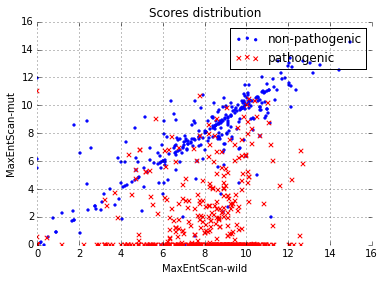

In [116]:
## Visualising the data

X, y = make_feature_matrix('tp.json', 'tn.json', algorithms = ['MaxEntScan'])
from splice_svm import *
%matplotlib inline
plot_Xy(X, y)

## Logistic Regression with one algorithm only

> Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.


Two features: MaxEntScan-wild and MaxEntScan-mut

In [117]:
X, y = make_feature_matrix('tp.json', 'tn.json', algorithms = ['MaxEntScan'])

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
kf = StratifiedKFold (y, n_folds=5, shuffle=True)

lr = LogisticRegression(fit_intercept=True) # set to False to have intercept=0

y_pred = np.zeros(len(y)) # where we'll accumulate predictions
for train_index, test_index in kf:
    # for each iteration of the for loop we'll do a test train split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    t = StandardScaler()
    X_train = t.fit_transform(X_train)
    lr.fit(X_train, y_train) # Train on the training data

    X_test = t.transform(X_test)
    y_pred[test_index] = lr.predict(X_test) # Predict using the test and store in y_pred
conf_matrix = metrics.confusion_matrix(y, y_pred)
print conf_matrix

[[354  20]
 [ 69 404]]


In [118]:
from splice_svm import *
cf = stats(conf_matrix)

print 'Sensitivity {:.2%}'.format(cf['Sensitivity'])
print 'Specificity {:.2%}'.format(cf['Specificity'])

Sensitivity 83.69%
Specificity 95.28%


Equation of the dark line:

## ROC of the Logistic Regression ML classifier with 1 algorithm

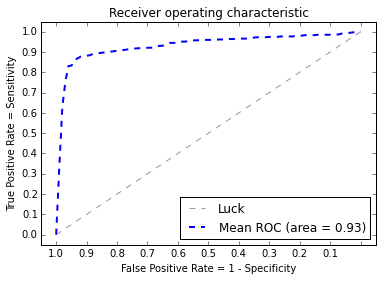

In [119]:
from scipy import interp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

X, y = make_feature_matrix('tp.json', 'tn.json', algorithms = ['MaxEntScan'])

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

fig, ax = plt.subplots()
lr = LogisticRegression(fit_intercept=True) # set to False to have intercept=0

for i, (train, test) in enumerate(kf):
    probas_ = lr.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    #ax.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(kf)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
ax.plot(mean_fpr, mean_tpr, 'b--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xticks(np.arange(0, 1.1, .1))
ax.set_xticklabels(np.arange(1.0, 0.0, -.1))
ax.set_yticks(np.arange(0, 1.1, .1))
ax.set_yticklabels(np.arange(0, 1.1, .1))

ax.set_xlabel('False Positive Rate = 1 - Specificity')
ax.set_ylabel('True Positive Rate = Sensitivity')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")

In [120]:
print lr.coef_
print lr.intercept_
print lr.score(X,y)

[[ 0.607586   -0.72855489]]
[-0.86598247]
0.896103896104


### Optimizing for Sensitivity?

The default boundary for the Decision Function is 0.50.

However, changing it will change both SPC and SEN along the ROC curve

In [121]:
idxs = [85, 90]
for idx in idxs:
    print 'Specificity %.2f, Sensitivity %.2f, Threshold %.4f' % (1-fpr[idx], tpr[idx], thresholds[idx])

Specificity 0.91, Sensitivity 0.90, Threshold 0.3630
Specificity 0.68, Sensitivity 0.95, Threshold 0.2839


## Using a single score (MaxEntScan-mut alone)

In [122]:
X, y = make_feature_matrix('tp.json', 'tn.json', algorithms = ['MaxEntScan'])
X = np.delete(X,0, axis=1) # use only the MaxEntScan-mut score

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
kf = StratifiedKFold (y, n_folds=5, shuffle=True)

lr = LogisticRegression(fit_intercept=True) # set to False to have intercept=0

y_pred = np.zeros(len(y)) # where we'll accumulate predictions
for train_index, test_index in kf:
    # for each iteration of the for loop we'll do a test train split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    t = StandardScaler()
    X_train = t.fit_transform(X_train)
    lr.fit(X_train, y_train) # Train on the training data

    X_test = t.transform(X_test)
    y_pred[test_index] = lr.predict(X_test) # Predict using the test and store in y_pred
conf_matrix = metrics.confusion_matrix(y, y_pred)
print conf_matrix
from splice_svm import *
cf = stats(conf_matrix)

print 'Sensitivity {:.2%}'.format(cf['Sensitivity'])
print 'Specificity {:.2%}'.format(cf['Specificity'])

[[272 102]
 [ 70 403]]
Sensitivity 79.53%
Specificity 79.80%


Not very good, but possible!

## Decision Trees

Play with 
  - algorithms
  - use_ratio
  - max_depth
  - min_samples_leaf

In [123]:
from splice_svm import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree, cross_validation, metrics

# Load the diabetes dataset
X, y = make_feature_matrix('tp.json', 'tn.json', algorithms = ['MaxEntScan'], use_ratio=True)
y = [y_ if y_==1 else -1 for y_ in y] # Decision trees use [-1, 1] for binary problems

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4)

# Create and train classifier
clf = tree.DecisionTreeClassifier(max_depth=2,  min_samples_leaf=10)
clf = clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test)

# The coefficients
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print conf_matrix
cf = stats(conf_matrix)

print 'Sensitivity {:.2%}'.format(cf['Sensitivity'])
print 'Specificity {:.2%}'.format(cf['Specificity'])

[[135  17]
 [ 19 168]]
Sensitivity 87.66%
Specificity 90.81%


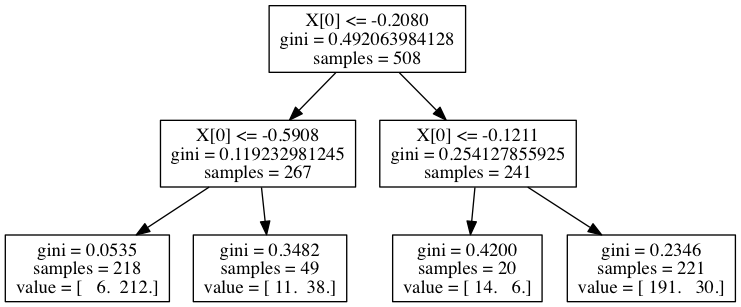

In [124]:
from sklearn.externals.six import StringIO
with open("splice_decisiontree.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)
#import os
#os.unlink('iris.dot')
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png("splice_decisiontree.png")
from IPython.display import Image
i = Image(filename='splice_decisiontree.png')
i

## Manual: keep simple

**Goal**: design one algorithm that can be used with Alamut, ie. by saying "IF Algorithm_A decreases by threshold_A% AND algorithm_B decrease by threshold_B% THEN `lost_site`."

### classifier code

In [125]:
import numpy as np
class basic_classifier(object):
    def __init__(self, threshold=[0.0]):
        if type(threshold) != np.ndarray:
            threshold = np.array(threshold)
        self.threshold = threshold
                
    def predict(self, X):
        if type(X) != np.ndarray:
            X = np.array(X)
        try:
            res = np.all(X < self.threshold, axis=1)
        except:
            res = np.all(X < self.threshold)
        return res

### Test unit

In [126]:
import unittest
class TestBasicClassifier(unittest.TestCase):
    def setUp(self):
        self.data = [
            {'threshold': [0], 'ratio': [0], 'result': False},
            {'threshold': [0], 'ratio': [-.25], 'result': True},
            {'threshold': [0,0], 'ratio': [0, 0], 'result': False},
            {'threshold': [0,0], 'ratio': [-.25, -.25], 'result': True},
            {'threshold': [0,0], 'ratio': [-.25, 0], 'result': False},            
            {'threshold': [0,0], 'ratio': [0, -1], 'result': False},
            {'threshold': [0,0], 'ratio': [[0, -1], [-0.1,-0.1]], 'result': [False, True]} 
        ]
    def test(self):
        for d in self.data:
            bc = basic_classifier(d['threshold'])
            res = bc.predict(d['ratio'])
            np.testing.assert_array_equal(res, d['result'])
            
suite = unittest.TestLoader().loadTestsFromTestCase(TestBasicClassifier)
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### play out different algorithms and thresholds

In [127]:
algorithms = ['MaxEntScan', 'SSFL'] # <-- change algo's here, eg ['MaxEntScan', 'SSFL']
thresholds = [-.15, -.05] # <-- change thresholds here [-0.15, -0.05]

from splice_svm import *
import matplotlib.pyplot as plt

from sklearn import tree, cross_validation, metrics

X, y = make_feature_matrix('tp.json', 'tn.json', algorithms = algorithms, use_ratio=True) 

clf = basic_classifier(thresholds) 
y_pred = clf.predict(X)

# The coefficients
conf_matrix = metrics.confusion_matrix(y, y_pred)
print conf_matrix
cf = stats(conf_matrix)

print 'Sensitivity {:.2%}'.format(cf['Sensitivity'])
print 'Specificity {:.2%}'.format(cf['Specificity'])
print 'Accuracy {:.2%}'.format(cf['Accuracy'])
print 'Positive predictive value {:.2%}'.format(cf['PPV'])
print 'Negative predictive value {:.2%}'.format(cf['NPV'])
print 'Positive likelihood ratio {:.2}'.format(cf['LR+'])
print 'Negative likelihood ratio {:.2}'.format(cf['LR-'])

[[351  23]
 [ 87 386]]
Sensitivity 80.14%
Specificity 94.38%
Accuracy 87.01%
Positive predictive value 93.85%
Negative predictive value 81.61%
Positive likelihood ratio 1.4e+01
Negative likelihood ratio 0.21


### varying one param and plot ROC

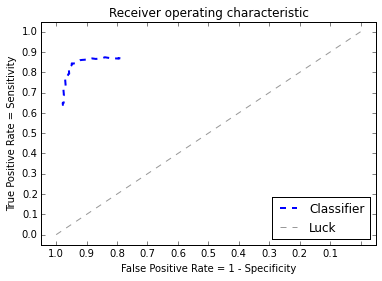

In [128]:
X, y = make_feature_matrix('tp.json', 'tn.json', algorithms = ['MaxEntScan'], use_ratio=True)

thr = np.arange(0, -1, -0.01)
clf = basic_classifier()
sen = []
spc = []
for t in thr:
    clf.threshold = [t]
    y_pred = clf.predict(X)
    conf_matrix = metrics.confusion_matrix(y, y_pred)
    cf = stats(conf_matrix)
    sen.append(cf['Sensitivity'])
    spc.append(cf['Specificity'])
    
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()

ax.plot([1-spc_ for spc_ in spc], sen, 'b--', lw=2, label='Classifier')

ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xticks(np.arange(0, 1.1, .1))
ax.set_xticklabels(np.arange(1.0, 0.0, -.1))
ax.set_yticks(np.arange(0, 1.1, .1))
ax.set_yticklabels(np.arange(0, 1.1, .1))

ax.set_xlabel('False Positive Rate = 1 - Specificity')
ax.set_ylabel('True Positive Rate = Sensitivity')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")

## Summary

| Method | Sensitivity (TPR) | Specificity (TNR)
| -- | -- |
| AMG HTS-diag | 92% | 76%
| AMG kreftgenetikk  | 82% | 91%
| Houdayer (our independent verification)  | 80% | 94%
| Support Vector Machines (SVM-5 algo's) | 84% | 96%
| Logistic Regression (LR-1 algo) - default boundary| 84% | 95%
| **Logistic Regression (LR-1 algo) - optimized boundary for Sensitivity** | 93% | 91% 
| **"manual" MaxEntScan -20%** | 86% | 92%


### Conclusion 

**For assessing splice sites, use only MaxEntScan. Classify as "`lost site`" when the variant score drops by more than 20% with respect to the wild score. (sensitivity 86%, specificity 92%)**